In [1]:
import h5py
import numpy as np
import skimage
import matplotlib.pyplot as plt
from astropy.io import ascii

from data.scripts.display_cutouts import stretch

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU') # need to trial and error to figure out which gpu I have been allocated. Not sure how else to get around this.

from supervised_model_prob import ImageRegressor

In [2]:
cutouts = h5py.File('/srv/scratch/mltidal/vd_cutouts.hdf', 'a')
print(list(cutouts.keys()))
for key in cutouts.keys():
    if int(key) > 54 and int(key) < 108:
        cutouts.copy(cutouts[key], str(int(key) + 53))
        del cutouts[key]
print(list(cutouts.keys()))

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '8', '9']
['0', '1', '10', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '6', '7', '8', '9']


In [2]:
# Open the clusters downloaded in the wide survey and look at them compared to 
# their deep counterparts
cutouts = h5py.File('/srv/scratch/mltidal/vd_cutouts.hdf')
cutouts_dud = h5py.File('/srv/scratch/z5214005/hsc_icl/cutouts.hdf')

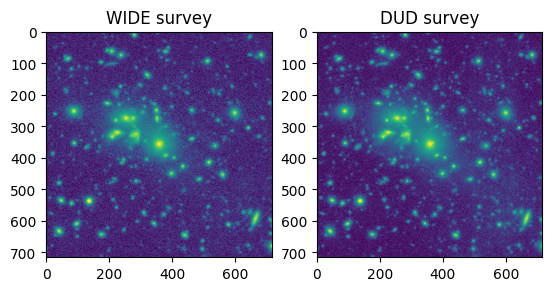

In [3]:
key = '0'

plt.subplot(121)
plt.imshow(stretch(cutouts[key]['HDU0']['DATA']))
plt.title('WIDE survey')
plt.subplot(122)
plt.title('DUD survey')
plt.imshow(stretch(cutouts_dud[key]['HDU0']['DATA']))
plt.show()

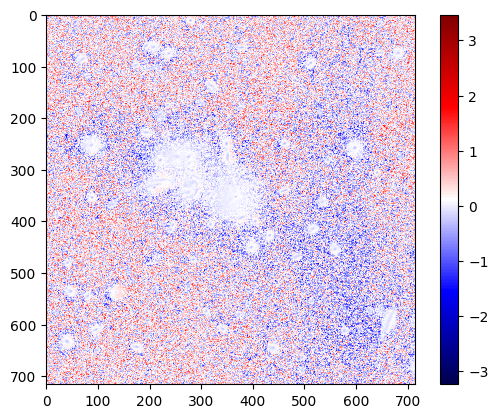

In [4]:
# What is the difference between the DUD and WIDE surveys?
key = '0'

residual = np.array(cutouts[key]['HDU0']['DATA']) - np.array(cutouts_dud[key]['HDU0']['DATA'])
plt.imshow(stretch(np.array(cutouts[key]['HDU0']['DATA'])) - stretch(np.array(cutouts_dud[key]['HDU0']['DATA'])), cmap='seismic')
plt.colorbar()
plt.show()

In [5]:
# What does the model predict on the wide images vs. the deep images?
model = ImageRegressor((224,224,1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=lambda y, p_y: -p_y.log_prob(y))
model.load_weights('checkpoint-sup-newdatacont.ckpt').expect_partial()

# Try one image
key = '0'
cutout = np.array(cutouts[key]['HDU0']['DATA'])
img = skimage.transform.resize(cutout, (224,224))
img = np.clip(img, a_min=0, a_max=10)
img = np.arcsinh(img / 0.017359)
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)

prediction = model(img).mean().numpy().squeeze()
print(f'Wide prediction = {prediction}')

cutout = np.array(cutouts_dud[key]['HDU0']['DATA'])
img = skimage.transform.resize(cutout, (224,224))
img = np.clip(img, a_min=0, a_max=10)
img = np.arcsinh(img / 0.017359)
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)
prediction = model(img).mean().numpy().squeeze()
print(f'Deep prediction = {prediction}')

2023-09-22 09:45:50.641582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-22 09:45:51.184575: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 09:45:51.184948: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 09:45:51.184968: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-09-22 09:45:51.185455: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 09:45:51.185501: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-09-22 09:45:52.073709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-09-22 09:45:52.073828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-09-22 09:45:52.080923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-09-22 09:45:52.081003: I tens

Wide prediction = 0.2820293605327606
Deep prediction = 0.5697412490844727


In [6]:
# Look at the model's predictions compared to the expected fractions
fracs = np.load('/srv/scratch/z5214005/precalc_fracs/fracs.npy')[2]
not_nans = np.where(~np.isnan(fracs))[0]

# Create an array of images that we have fractions for
dataset = []
expected = []
valid_ids = []
for idx in not_nans:
    if str(idx) not in cutouts:
        continue
    cutout = np.array(cutouts[str(idx)]['HDU0']['DATA'])
    img = skimage.transform.resize(cutout, (224,224))
    img = np.clip(img, a_min=0, a_max=10)
    img = np.arcsinh(img / 0.017359)
    img = np.expand_dims(img, -1)
    dataset.append(img)
    expected.append(fracs[idx])
    valid_ids.append(idx)

dataset = np.array(dataset)

In [7]:
# Get predictions for all of these fractions
predictions = model(dataset).mean().numpy().squeeze()
predictions

2023-09-22 09:45:54.467772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-09-22 09:45:54.468338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-09-22 09:45:54.475941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-09-22 09:45:54.476013: I tens

array([0.27850434, 0.18197276, 0.10217316, 0.18977132, 0.27234626,
       0.18416187, 0.18577361, 0.12519154, 0.24175614, 0.11535889,
       0.17427424, 0.17856784, 0.07955955, 0.15385395, 0.25044227,
       0.22858104, 0.2563419 , 0.22849771, 0.25842297, 0.24257468,
       0.2971845 , 0.18854979, 0.13264452, 0.14921407, 0.3690755 ,
       0.48795378, 0.27595907, 0.09599674, 0.31104353, 0.41473067,
       0.21289851, 0.4163218 , 0.493437  , 0.3982627 , 0.36066416,
       0.20099506, 0.20881625, 0.40696508, 0.3309982 , 0.3376446 ,
       0.45143774, 0.31045723, 0.26588112, 0.3857791 , 0.22513585,
       0.28890175, 0.16678165, 0.3225494 , 0.06043897, 0.04350023,
       0.31380635, 0.27053168, 0.04875451, 0.24520802, 0.25844654,
       0.25915855, 0.38536114, 0.07773818, 0.23754172, 0.09926783,
       0.39170352, 0.18927962, 0.16723129], dtype=float32)

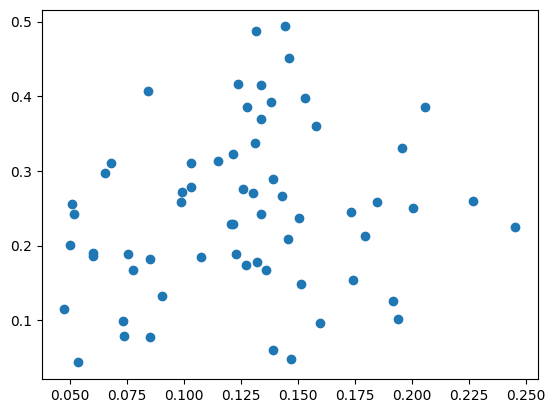

In [8]:
plt.scatter(expected, predictions)
plt.show()